### Imports, loading features and DB

In [1]:
# improve speed of SVC in sklearn
from sklearnex import patch_sklearn
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import sys
sys.path.insert(0, '../..')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from metrics.metrics_utils import get_froc_df_of_many_imgs_features
from metrics.metrics import froc_curve
from general_utils.plots import plot_froc
import seaborn as sns
from database.dataset import *
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

# set the seed for reproducible execution
rseed = np.random.seed(42)


In [4]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['train', 'validation'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)


Load the features data

In [7]:
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria

In [5]:
features_data = pd.read_feather(
    '/home/vzalevskyi/projects/data/features/morph/cand_features_df.f')
fnsdf = pd.read_feather(
    '/home/vzalevskyi/projects/data/features/morph/fns_df.f')
ignored = pd.read_feather(
    '/home/vzalevskyi/projects/data/features/morph/ingnored_df.f')

In [6]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_' in x]
wavelet_cols = [x for x in features_data if x[:6]
                == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if 'haar' in x]

features_sets = {'fos': fos_cols, 'gabor': gabor_cols, 'wavelet': wavelet_cols,
                 'haar': haar_cols,
                 'all_features': fos_cols+gabor_cols+wavelet_cols+haar_cols}


# Grid-Search

In [ ]:
param_grid = [
    {'SVC__C': [1, 10, 100], 'SVC__kernel': ['linear']},
    {'SVC__C': [1, 10, 100, ], 'SVC__degree':[
        3, 5, 7, 10], 'SVC__kernel': ['poly']},
    {'SVC__C': [1, 10, 100, ], 'SVC__gamma': [
        0.001, 0.01, 0.1, 1], 'SVC__kernel': ['rbf']},
]


pipe = Pipeline([('scaler', MinMaxScaler()), ('SVC', SVC())])


clf = GridSearchCV(estimator=pipe,
                   param_grid=param_grid,
                   scoring='roc_auc',
                   n_jobs=4,
                   cv=5)


FP2TP_rate = 10
positive_mask = (features_data.label > 0)
positive_train_part = features_data[positive_mask]
negative_train_part = features_data[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())
train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)
train_y = train_df.label
train_X = train_df[features_sets['all_features']]

clf.fit(train_X, train_y)


In [ ]:
clf.best_estimator_['SVC'].get_params()


{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Cascade

### First Stage (removing easy negative)

In [7]:
clf = SVC(**{'C': 10,
             'break_ties': False,
             'cache_size': 200,
             'class_weight': None,
             'coef0': 0.0,
             'decision_function_shape': 'ovr',
             'degree': 3,
             'gamma': 0.1,
             'kernel': 'rbf',
             'max_iter': -1,
             'probability': True,
             'random_state': 42,
             'shrinking': True,
             'tol': 0.001,
             'verbose': False})


In [8]:
# adding case_id column for case_wise K-fold CV splits
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()[
    'case_id']
features_data['case_id'] = [imgid2caseid[imgid]
                            for imgid in features_data['img_id']]


In [9]:
# splitting all candidates between db train and validation partitions

all_train_db_ids = db.df[db.df.partition == 'train'].img_id.values
all_valid_db_ids = db.df[db.df.partition == 'validation'].img_id.values

general_train_mask = features_data.img_id.isin(all_train_db_ids)
general_valid_mask = features_data.img_id.isin(all_valid_db_ids)

train_features = features_data[general_train_mask]
test_features = features_data[general_valid_mask]


In [10]:
kfolds = 10
FP2TP_rate = 10

features = features_sets['all_features']

# splitting data into train/validation case-wise
all_train_case_ids = train_features.case_id.unique()
kfolds_case_splits = np.array_split(all_train_case_ids, kfolds)

predicted_test_df = []
balanced_train_df = []

# kfold CV
for valid_case_ids in tqdm(kfolds_case_splits):

    # split data into test
    test_split_mask = train_features.case_id.isin(valid_case_ids)

    # split into train and take into account cleaned data with no mC in the borders of the patch
    cleaned_features_data = train_features[~test_split_mask]

    # and sampling to a predefined 1:FP2TP_rate TP:FP samples
    positive_mask = (cleaned_features_data.label > 0)
    positive_train_part = cleaned_features_data[positive_mask]
    negative_train_part = cleaned_features_data[~positive_mask].sample(
        FP2TP_rate*positive_mask.sum())

    train_df = pd.concat(
        [positive_train_part, negative_train_part]).sample(frac=1.)

    test_df = train_features[test_split_mask]

    train_y = train_df.label
    test_y = test_df.label

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_df[features].values)
    test_X_scaled = scaler.transform(test_df[features].values)

    clf.fit(train_X_scaled, train_y)

    train_y_predicted = clf.predict_proba(train_X_scaled)[:, 1]
    test_y_predicted = clf.predict_proba(test_X_scaled)[:, 1]

    test_df['cv_fold_predict_proba'] = test_y_predicted
    predicted_test_df.append(test_df)


  0%|          | 0/5 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_96899/2053056035.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cv_fold_predict_proba'] = test_y_predicted
 20%|██        | 1/5 [00:22<01:28, 22.02s/it]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC

In [11]:
predicted_test_df = pd.concat(predicted_test_df)

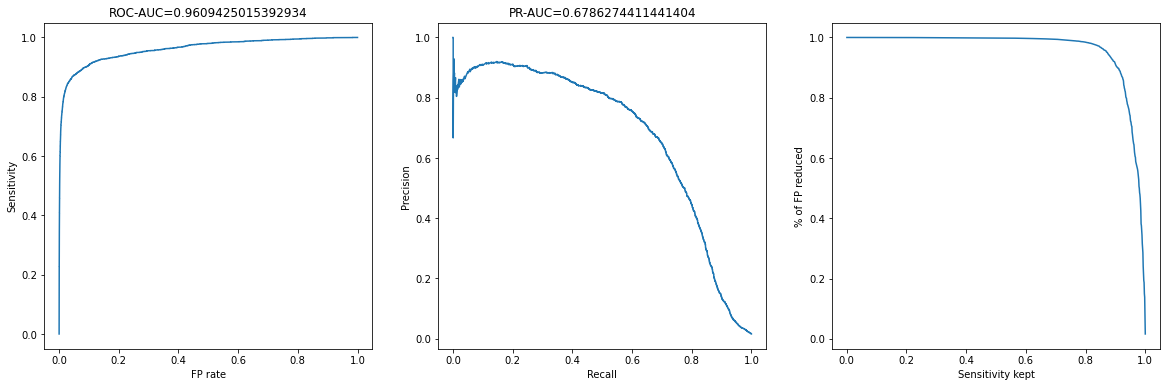

In [33]:
fpr, tpr, thrs = roc_curve(predicted_test_df.label,
                           predicted_test_df.cv_fold_predict_proba)

prc, rc, thrs_pr = precision_recall_curve(
    predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)

filtered_fp_prc = []
total_fp = np.sum(~predicted_test_df.label)
for ks in np.linspace(0, 1, num=1000):

    max_conf_thr_required = thrs[np.argmax(tpr >= ks)]

    filtered_fp = np.sum((~predicted_test_df.label) & (
        predicted_test_df.cv_fold_predict_proba <= max_conf_thr_required))/total_fp
    filtered_fp_prc.append(filtered_fp)


fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(
    f'ROC-AUC={roc_auc_score(predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(np.linspace(0.001, 1, num=1000), filtered_fp_prc)
axs[2].set_xlabel('Sensitivity kept')
axs[2].set_ylabel('% of FP reduced')
plt.show()


In [52]:
cascade1_tpr = tpr.copy()
cascade1_thrs = thrs.copy()
cascade1_labels = predicted_test_df.label.values
cascade1_probas = predicted_test_df.cv_fold_predict_proba.values

keep_sens_thr = .98
max_conf_thr_required = cascade1_thrs[np.argmax(cascade1_tpr >= keep_sens_thr)]

filtered_fp = np.sum((~cascade1_labels) & (
    cascade1_probas <= max_conf_thr_required))/total_fp


msg = (
    f"Selected keep_sens_thr={keep_sens_thr}\n"
    f'max_conf_thr_required to keep given sensitivity is {max_conf_thr_required:.5f}\n'
    f'Filtering out all candidates with confidence <={max_conf_thr_required:.5f} is estimated to reduce FP by {100*filtered_fp:.2f} %'
)
print(msg)

Selected keep_sens_thr=0.98
max_conf_thr_required to keep given sensitivity is 0.00380
Filtering out all candidates with confidence <=0.00380 is estimated to reduce FP by 49.97 %


### Displaying removed easy negatives

In [14]:
removed_easy_negatives = predicted_test_df[predicted_test_df.cv_fold_predict_proba <= max_conf_thr_required].sample(
    100)
removed_easy_negatives


,haar_0,haar_1,haar_2,haar_3,haar_4,haar_5,haar_6,haar_7,haar_8,haar_9,...,patch_glcm_dissimilarity_HH1_1,patch_glcm_dissimilarity_HH1_2,candidate_coordinates,patch_coordinates,img_id,repeted_idxs,matching_gt,label,case_id,cv_fold_predict_proba
32407,-0.267212,-0.286575,0.047332,0.106713,0.012048,-0.326592,0.141997,0.072719,0.024096,-0.307229,...,57.111111,65.828571,"[737, 2230, 0]","[[2223, 2237], [730, 744]]",22580654,292.0,NaN,False,fe7d005dcbbfb46d,0.000590
132618,-0.085122,-0.167740,0.072961,0.111230,0.103004,-0.193848,0.081187,0.139127,0.110157,-0.111230,...,69.111111,49.971429,"[620, 1898, 0]","[[1891, 1905], [613, 627]]",27829134,540.0,NaN,False,fbb55bf7fff48540,0.000816
25453,-0.066638,-0.119518,0.199054,0.328891,0.278160,-0.131556,0.249785,0.240327,0.287618,-0.078676,...,80.805556,73.257143,"[245, 1370, 0]","[[1363, 1377], [238, 252]]",20587810,1091.0,NaN,False,81cd83d2f4d78528,0.001718
203762,-0.106522,-0.144783,0.033913,0.107826,0.023478,-0.137826,0.118261,0.104783,0.008261,-0.099565,...,76.194444,75.685714,"[1101, 1771, 4]","[[1764, 1778], [1094, 1108]]",50997053,782.0,NaN,False,ce5e5e18a261cd29,0.002343
216385,-0.113772,-0.172056,0.112176,0.111776,0.063473,-0.177246,0.160479,0.191218,0.061477,-0.118962,...,56.222222,66.457143,"[194, 854, 0]","[[847, 861], [187, 201]]",50997488,1779.0,NaN,False,97ec8cadfca70d32,0.002449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121763,-0.084284,-0.053995,0.215979,0.403863,0.247586,-0.139157,0.372256,0.293240,0.349429,-0.169447,...,74.277778,79.942857,"[405, 432, 2]","[[425, 439], [398, 412]]",24065611,879.0,NaN,False,d8205a09c8173f44,0.002657
13834,-0.062181,-0.052900,0.163805,0.207889,0.147564,-0.102088,0.224130,0.230626,0.109977,-0.111369,...,61.111111,60.085714,"[173, 1567, 0]","[[1560, 1574], [166, 180]]",20587518,506.0,NaN,False,d571b5880ad2a016,0.000643
199214,-0.079545,-0.096946,0.303977,0.546875,0.431818,-0.083452,0.419034,0.414773,0.488636,-0.066051,...,77.388889,76.628571,"[649, 2166, 0]","[[2159, 2173], [642, 656]]",50996972,853.0,NaN,False,ce5e5e18a261cd29,0.003217
215975,0.065070,0.049900,-0.146108,-0.156088,-0.132136,0.041916,-0.170060,-0.196008,-0.129341,0.057086,...,48.638889,55.400000,"[485, 1093, 0]","[[1086, 1100], [478, 492]]",50997488,1369.0,NaN,False,97ec8cadfca70d32,0.000716


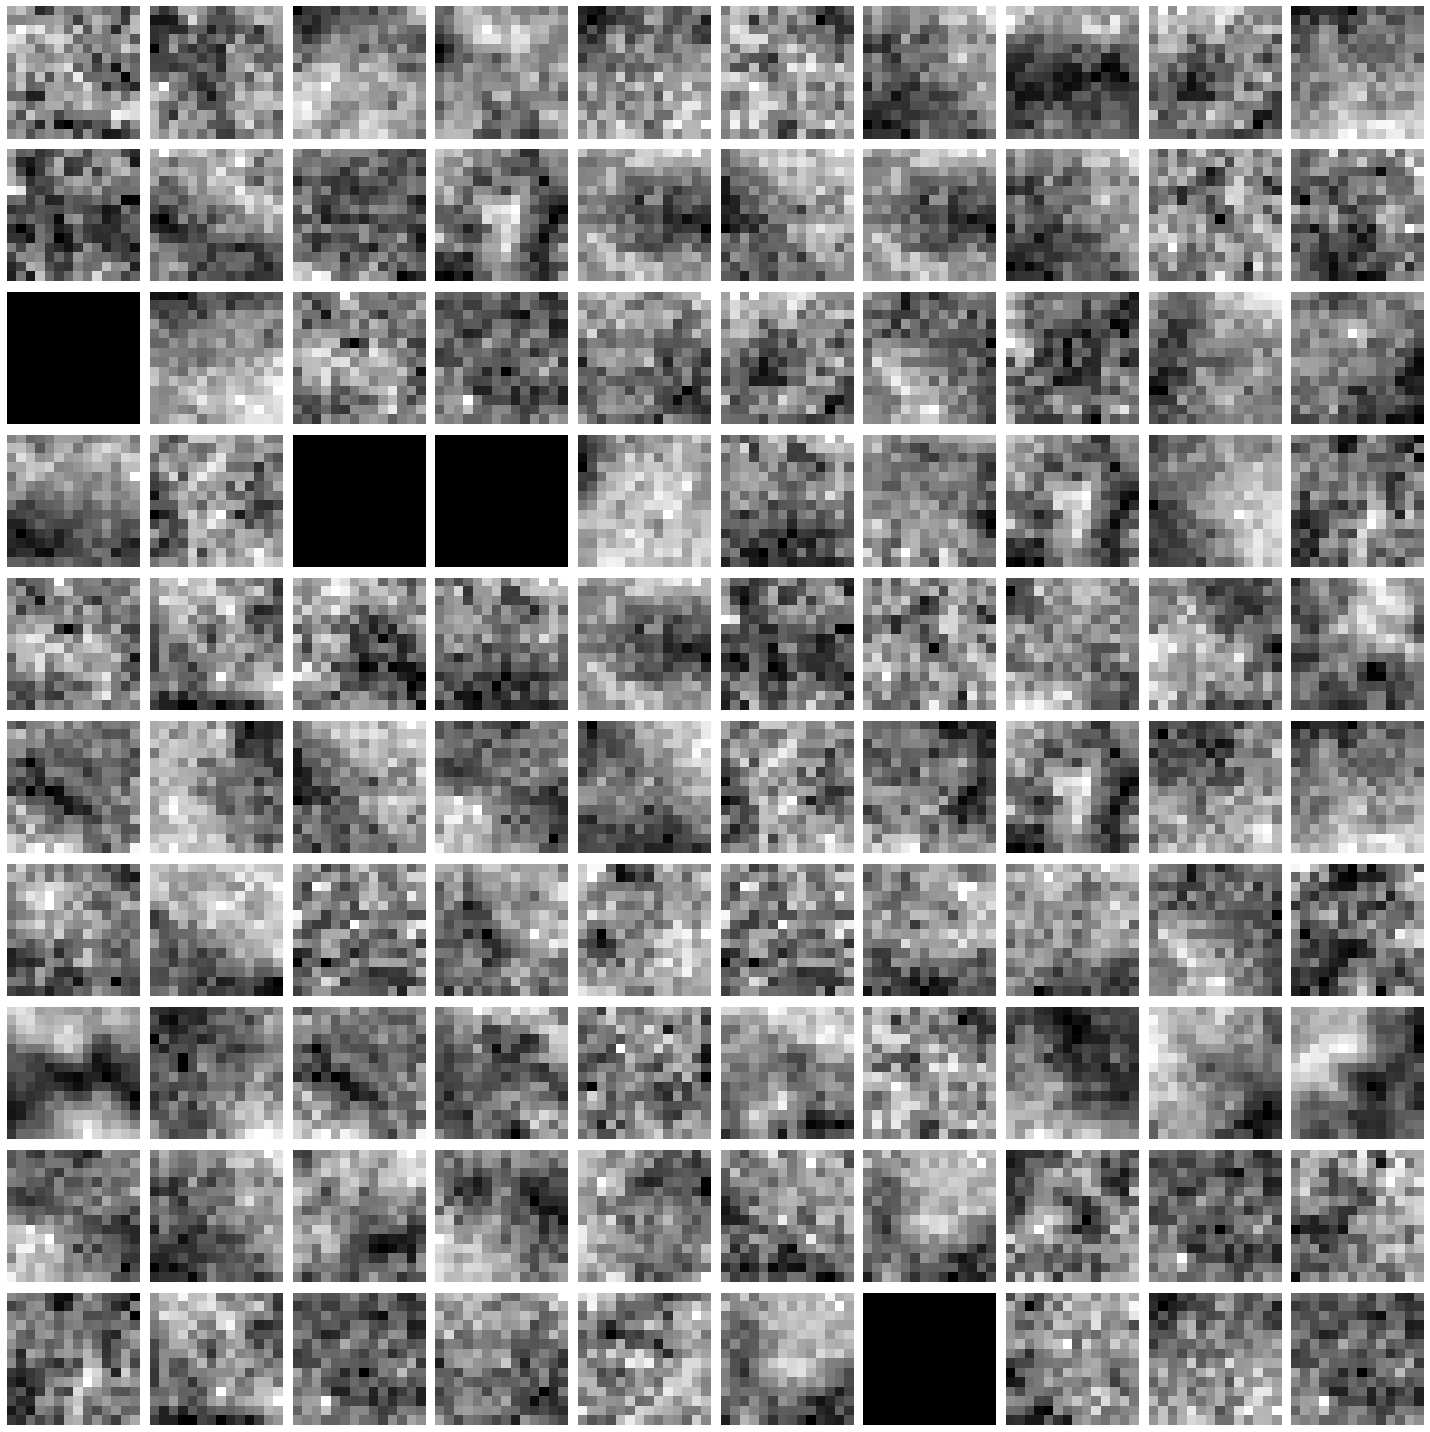

In [15]:
img_plot_idx = 0

fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(20, 20))

for r in range(10):
    for c in range(10):
        img_idx = db.df[db.df.img_id ==
                        removed_easy_negatives.iloc[img_plot_idx].img_id].index[0]
        image = db[img_idx]['img']
        (y1, y2), (x1, x2) = removed_easy_negatives.iloc[0].patch_coordinates
        axs[r, c].imshow(image[y1:y2, x1:x2], cmap='gray')
        axs[r, c].set_axis_off()

        img_plot_idx += 1

plt.tight_layout()
# plt.title('Removed Easy negatives')
plt.show()


Training final first stage model



In [16]:
# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_features.label > 0)
positive_train_part = train_features[positive_mask]
negative_train_part = train_features[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())


train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)

first_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
first_stage_model.fit(train_df[features], train_df.label)


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc',
                 SVC(C=10, gamma=0.1, probability=True, random_state=42))])

### Second Stage (retraining on harder samples)

In [17]:
print(max_conf_thr_required)
train_df_stage2 = predicted_test_df[predicted_test_df.cv_fold_predict_proba >
                                    max_conf_thr_required]


0.003795811478854027


In [18]:
print(len(predicted_test_df), len(train_df_stage2))


202729 102928


In [19]:
kfolds = 10
FP2TP_rate = 10

features = features_sets['all_features']
# splitting data into train/validation case-wise
all_train_case_ids = train_df_stage2.case_id.unique()
kfolds_case_splits = np.array_split(all_train_case_ids, kfolds)

predicted_test_df2 = []

# kfold CV
for valid_case_ids in tqdm(kfolds_case_splits):

    # split data into test
    test_split_mask = train_df_stage2.case_id.isin(valid_case_ids)

    # split into train and take into account cleaned data with no mC in the borders of the patch
    cleaned_features_data = train_df_stage2[~test_split_mask]

    # and sampling to a predefined 1:FP2TP_rate TP:FP samples
    positive_mask = (cleaned_features_data.label > 0)
    positive_train_part = cleaned_features_data[positive_mask]
    negative_train_part = cleaned_features_data[~positive_mask].sample(
        FP2TP_rate*positive_mask.sum())

    train_df = pd.concat(
        [positive_train_part, negative_train_part]).sample(frac=1.)

    test_df = train_df_stage2[test_split_mask]

    train_y = train_df.label
    test_y = test_df.label

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_df[features].values)
    test_X_scaled = scaler.transform(test_df[features].values)

    clf.fit(train_X_scaled, train_y)

    train_y_predicted = clf.predict_proba(train_X_scaled)[:, 1]
    test_y_predicted = clf.predict_proba(test_X_scaled)[:, 1]

    test_df['cv_fold_predict_proba'] = test_y_predicted
    predicted_test_df2.append(test_df)


  0%|          | 0/5 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_96899/1239163999.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cv_fold_predict_proba'] = test_y_predicted
 20%|██        | 1/5 [00:18<01:14, 18.65s/it]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC

In [20]:
predicted_test_df2 = pd.concat(predicted_test_df2)


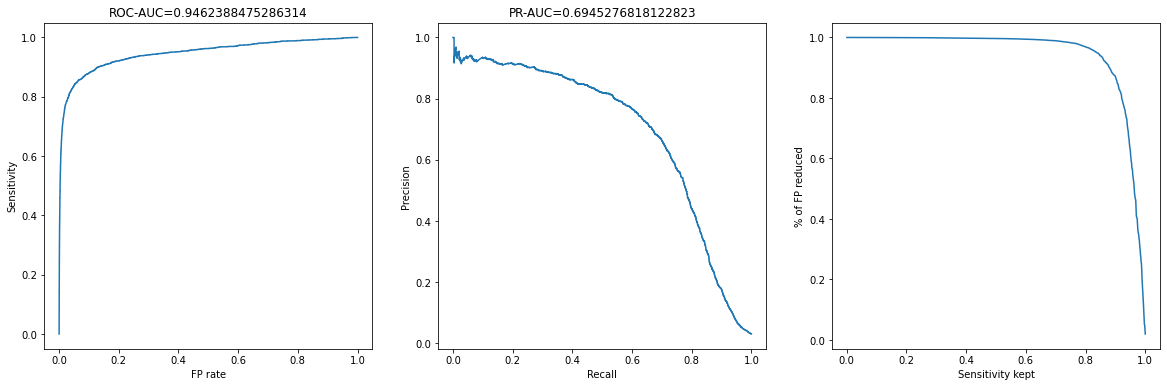

In [21]:
fpr, tpr, thrs = roc_curve(predicted_test_df2.label,
                           predicted_test_df2.cv_fold_predict_proba)

prc, rc, thrs_pr = precision_recall_curve(
    predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)

filtered_fp_prc = []
total_fp = np.sum(~predicted_test_df2.label)
for ks in np.linspace(0.001, 1, num=1000):

    keep_sens_thr = ks
    max_conf_thr_required = thrs[np.argmax(tpr >= keep_sens_thr)]

    filtered_fp = np.sum((~predicted_test_df2.label) & (
        predicted_test_df2.cv_fold_predict_proba <= max_conf_thr_required))/total_fp
    filtered_fp_prc.append(filtered_fp)


fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(
    f'ROC-AUC={roc_auc_score(predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(np.linspace(0.001, 1, num=1000), filtered_fp_prc)
axs[2].set_xlabel('Sensitivity kept')
axs[2].set_ylabel('% of FP reduced')
plt.show()


In [22]:
# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_df_stage2.label > 0)
positive_train_part = train_df_stage2[positive_mask]
negative_train_part = train_df_stage2[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())


train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)

second_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
second_stage_model.fit(train_df[features], train_df.label)


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc',
                 SVC(C=10, gamma=0.1, probability=True, random_state=42))])

In [23]:
train_df_stage2.label.sum()/len(train_df_stage2)


0.029875252603761854

### Final comparison between clssifiers

In [14]:
# load models directly
# with open('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl', 'rb') as f:
#     first_stage_model, second_stage_model, cascade1_tpr, cascade1_thrs, cascade1_labels, cascade1_probas, keep_sens_thr = pickle.load(f)


In [15]:
val1st_pred = first_stage_model.predict_proba(test_features[features])[:, 1]
val2st_pred = second_stage_model.predict_proba(test_features[features])[:, 1]

INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


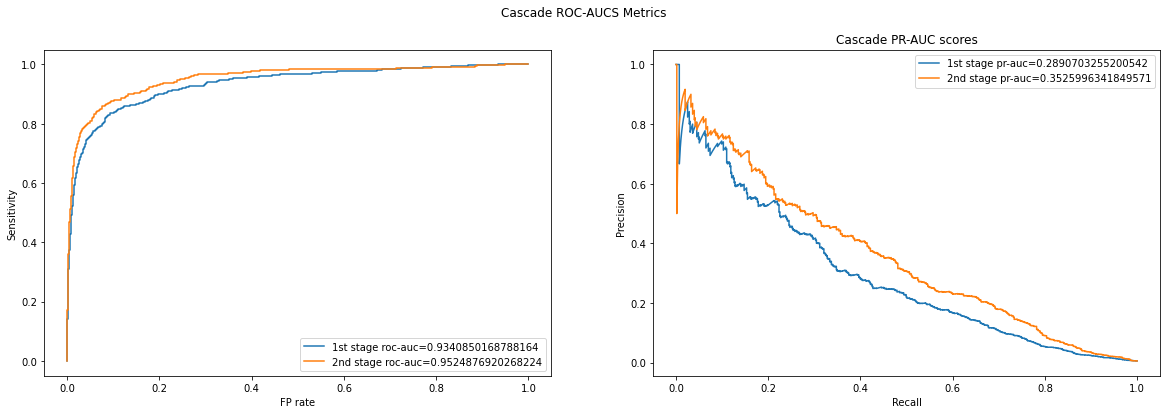

In [16]:
fpr_train1, tpr_train1, _ = roc_curve(test_features.label, val1st_pred)
prc_train1, rc_train1, _ = precision_recall_curve(
    test_features.label, val1st_pred)

fpr_test2, tpr_test2, _ = roc_curve(test_features.label, val2st_pred)
prc_test2, rc_test2, _ = precision_recall_curve(
    test_features.label, val2st_pred)


fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Cascade ROC-AUCS Metrics')
axs[0].plot(fpr_train1, tpr_train1)
axs[0].plot(fpr_test2, tpr_test2)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].legend([f'1st stage roc-auc={roc_auc_score(test_features.label, val1st_pred, )}',
               f'2nd stage roc-auc={roc_auc_score(test_features.label, val2st_pred)}'])

axs[1].plot(rc_train1, prc_train1)
axs[1].plot(rc_test2, prc_test2)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'Cascade PR-AUC scores')
axs[1].legend([f'1st stage pr-auc={auc(rc_train1, prc_train1)}',
               f'2nd stage pr-auc={auc(rc_test2, prc_test2)}'])


plt.show()


In [21]:
valid_fnsdf

,x,y,radius,label,matching_gt,repeted_idxs,img_id,detection_labels,pred_scores
8,790,2008,0.0,FN,None,False,20587320,FN,0.0
9,526,706,0.0,FN,None,False,20587320,FN,0.0
10,532,222,0.0,FN,None,False,20587320,FN,0.0
11,541,225,0.0,FN,None,False,20587320,FN,0.0
12,89,2847,0.0,FN,None,False,20587320,FN,0.0
...,...,...,...,...,...,...,...,...,...
424,1426,2300,0.0,FN,None,False,50993670,FN,0.0
425,1347,1456,0.0,FN,None,False,50993697,FN,0.0
772,369,3114,0.0,FN,None,False,50996709,FN,0.0
805,241,1716,11.0,FN,None,False,51048918,FN,0.0


In [17]:
valid_fnsdf = fnsdf[fnsdf.img_id.isin(test_features.img_id.unique())]


In [18]:
normal_imgs_ids = db.get_normal_imgs_ids()


froc_df_1st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val1st_pred,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(
    froc_df_1st, non_max_supression=True, cut_on_50fpi=True)


froc_df_2st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val2st_pred,
    normal_imgs_ids
)

sens2, avgs_fp_per_image2, _ = froc_curve(
    froc_df_2st, non_max_supression=True, cut_on_50fpi=True)


froc_df_cascade = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val2st_pred,
    normal_imgs_ids
)

sens_casc, avgs_fp_per_image_casc, _ = froc_curve(
    froc_df_cascade, non_max_supression=True, cut_on_50fpi=True)

/home/vzalevskyi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/vzalevskyi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


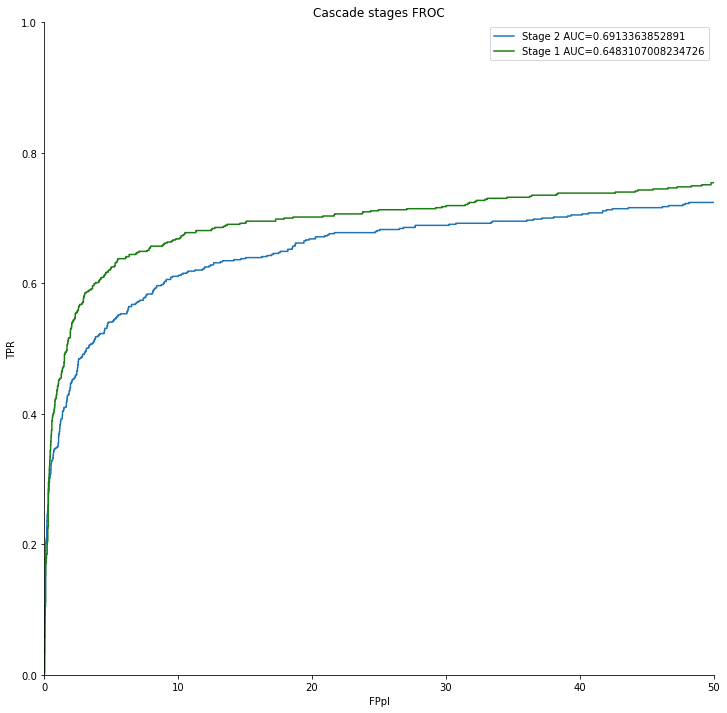

In [19]:

fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(1, 1, 1)

plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs, color=(0.12, 0.46, 0.7, 1.0))


plot_froc(avgs_fp_per_image2, sens2, title='Cascade stages FROC',
          cut_on_50fpi=True, ax=axs, color=(0.1, 0.49, 0.07, 1.0))
avgs_fp_per_image2 = np.asarray(avgs_fp_per_image2)
avgs_fp_per_image1 = np.asarray(avgs_fp_per_image1)
plt.legend([f'Stage 2 AUC={auc(avgs_fp_per_image2/avgs_fp_per_image2.max(), sens2)}',
            f'Stage 1 AUC={auc(avgs_fp_per_image1/avgs_fp_per_image1.max(), sens1)}'])


# Looking into bad results

Save locally some examples of bad predictions or missed candidates

In [36]:
test_features['confidence'] = val2st_pred

test_df = test_features


/tmp/ipykernel_220314/2031025059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['confidence'] = val2st_pred


In [37]:
bad_res_FP = test_df[~test_df.label].sort_values(
    by=['confidence'], ascending=False).drop(columns=features_sets['all_features'])
bad_res_FN = test_df[test_df.label].sort_values(
    by=['confidence'], ascending=True).drop(columns=features_sets['all_features'])

bad_res_FN_normals = bad_res_FN[bad_res_FN.img_id.isin(
    db.get_normal_imgs_ids())]
bad_res_FP_normals = bad_res_FP[bad_res_FP.img_id.isin(
    db.get_normal_imgs_ids())]


for _, bad_res in tqdm(bad_res_FN.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    # ((2767, 2781), (1029, 1043))
    test_img_id = db.df[db.df.img_id == img_id].index.values[0]
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']

    original_test_mask = cv2.imread(
        str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2) = bad_res['patch_coordinates']

    if original_test_mask is not None:
        fig, axs = plt.subplots(4, 3, figsize=(20, 8))
        if db.img_df[db.img_df.img_id == img_id]['side'].values[0] == "R":
            original_test_mask = cv2.flip(original_test_mask, 1)
    else:
        fig, axs = plt.subplots(4, 2, figsize=(20, 8))
    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,
                            ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta,
                            ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')
        if original_test_mask is not None:
            axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2 +
                                delta, ppy1-delta:ppy2+delta] > 0, cmap='gray', vmin=0)
            axs[didx, 2].axis('off')
            axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_res_FN/conf={bad_res["confidence"]}_{img_id}_{_}.jpg',
                bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    plt.close(fig)


  5%|▌         | 5/100 [00:10<03:09,  2.00s/it]/tmp/ipykernel_112095/3175446880.py:24: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_112095/3175446880.py:28: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
/tmp/ipykernel_112095/3175446880.py:32: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


In [96]:
val2st_pred = second_stage_model.predict_proba(test_features[features])[:, 1]

INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


# Save cascade models

In [82]:
with open('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl', 'wb') as f:
    pickle.dump((first_stage_model, second_stage_model, 
                 cascade1_tpr, cascade1_thrs, 
                 cascade1_labels, cascade1_probas,
                 keep_sens_thr), f)
